# Using Neural Nerwork To Solve The AMSS Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm as tqdm 
import itertools 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
from matplotlib import ticker

In [2]:
input_policyFunction = 3
input_valueFunction = 2
output_policyFunction = 1
output_valueFunction = 1

## Define The Neural Network:  policy function: labor input; value function; transfer T

In [3]:
class NN_policyFunction(nn.Module):
    def __init__(self, 
                dim_hidden = 64,
                layers = 4,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        module_p = []
        module_p.append(nn.Linear(input_policyFunction ,self.dim_hidden, bias = self.hidden_bias))
        module_p.append(nn.ReLU())
        
        for i in range(self.layers-1):
            module_p.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module_p.append(nn.ReLU())
            
        module_p.append(nn.Linear(self.dim_hidden,output_policyFunction))
        module_p.append(nn.Sigmoid())
       
        self.u = nn.Sequential(*module_p)

    def forward(self, x):
        u_out = self.u(x)
        return  u_out

In [4]:
class NN_taxFunction(nn.Module):
    def __init__(self, 
                dim_hidden = 16,
                layers = 2,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        module_t = []
        module_t.append(nn.Linear(input_policyFunction ,self.dim_hidden, bias = self.hidden_bias))
        module_t.append(nn.ReLU())
        
        for i in range(self.layers-1):
            module_t.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module_t.append(nn.ReLU())
            
        module_t.append(nn.Linear(self.dim_hidden,output_policyFunction))
        module_t.append(nn.Sigmoid())
       
        self.u = nn.Sequential(*module_t)

    def forward(self, x):
        u_out = self.u(x)
        return  u_out

In [5]:
class NN_valueFunction(nn.Module):
    def __init__(self, 
                dim_hidden = 64,
                layers = 3,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        module_v = []
        module_v.append(nn.Linear(input_valueFunction,self.dim_hidden, bias = self.hidden_bias))
        module_v.append(nn.ReLU())
        
        for i in range(self.layers-1):
            module_v.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module_v.append(nn.ReLU())
            
        module_v.append(nn.Linear(self.dim_hidden,output_valueFunction))
        
        self.v =  nn.Sequential(*module_v)

    def forward(self, x):
        v_out = self.v(x)
        return  v_out

In [6]:
#State Variable Grid Points:
x_min = -3.4107
x_max = 3.709
x_num = 300
x_grid = torch.linspace(x_min,x_max,x_num).reshape(x_num,1)

#Batchsize of Grid Points:
Batch_size = 150

#Parameters:
ψ = 0.69
Π = torch.full((2, 2), 0.5)
β = 0.9
g = [0.1, 0.2]
Bound_T = 0.01

#Weights of Loss Functions
λ_n = 20
λ_T = 1800
ξ = 12

In [7]:
class Data_loader(Dataset):
    
    def __init__(self,data):
        self.x = data
        self.x_samples = self.x.shape[0]

    def __getitem__(self,index):
            return self.x[index]
        
    def __len__(self):
        return self.x_samples

In [8]:
softplus = nn.Softplus()

## Define The Loss Function

In [9]:
def Euler_residual(state):
    V0 =  -softplus(v_hat(state))-14.0
    s_ = state[:,1:].int()
    x_ = state[:,:1]
    Π_seq = []
    num = s_.size(0)
    for i in range(num):
        Π_seq.append(Π[s_[i,0],:])
    Π_s = torch.stack(Π_seq)
    
    current_s_0 = torch.cat((state,torch.zeros(num,1)),1)
    current_s_1 = torch.cat((state,torch.ones(num,1)),1)
    n_0 = g[0]+(1-g[0])*n_hat(current_s_0)
    n_1 = g[1]+(1-g[1])*n_hat(current_s_1)
    T_0 = Bound_T*T_hat(current_s_0)
    T_1 = Bound_T*T_hat(current_s_1)
    
    expected_marginal_utility = β * (Π_s[:,:1]/(n_0 - g[0])+Π_s[:,1:]/(n_1 - g[1]))
    current_x_0 = Variable(x_/(expected_marginal_utility*(n_0-g[0]))-1+ψ*n_0/(1-n_0)+T_0/(n_0-g[0]),requires_grad=True)
    current_x_1 = Variable(x_/(expected_marginal_utility*(n_1-g[1]))-1+ψ*n_1/(1-n_1)+T_1/(n_1-g[1]),requires_grad=True)
    
    current_state_0 = torch.cat((current_x_0,torch.zeros(num,1)),1)
    current_state_1 = torch.cat((current_x_1,torch.ones(num,1)),1)
    
    current_V_0 = torch.log(n_0-g[0])+ψ*torch.log(1-n_0) + β*(-softplus(v_hat(current_state_0))-14.0)
    current_V_1 = torch.log(n_1-g[1])+ψ*torch.log(1-n_1) + β*(-softplus(v_hat(current_state_1))-14.0)
    V0_compute = Π_s[:,:1]*current_V_0 +  Π_s[:,1:]*current_V_1
    residual_valueFunction = V0_compute - V0
    
    current_V_0.backward(torch.ones(num,1),retain_graph=True)
    V_0_prime = current_x_0.grad
    v_0_prime = torch.autograd.grad(current_V_0,current_x_0,grad_outputs = torch.ones(num,1),retain_graph=True, create_graph=True)[0]
    
    current_V_1.backward(torch.ones(num,1),retain_graph=True)
    V_1_prime = current_x_1.grad
    v_1_prime = torch.autograd.grad(current_V_1,current_x_1,grad_outputs = torch.ones(num,1),retain_graph=True, create_graph=True)[0]

    
    current_sum = β * (Π_s[:,1:]*(n_0 - g[0])+Π_s[:,:1]*(n_1 - g[1])).pow(2)
    partial_x0_n0 = -x_*Π_s[:,1:]*(n_1-g[1])/current_sum+ψ/((1-n_0).pow(2))-T_0/((n_0-g[0]).pow(2))
    partial_x0_n1 = x_*Π_s[:,1:]*(n_0-g[0])/current_sum
    partial_x1_n0 = x_*Π_s[:,:1]*(n_1-g[1])/current_sum
    partial_x1_n1 = -x_*Π_s[:,:1]*(n_0-g[0])/current_sum+ψ/((1-n_1).pow(2))-T_1/((n_1-g[1]).pow(2))
                                                          
    residual_V_n0 = Π_s[:,:1]*(1/(n_0-g[0])-ψ/(1-n_0)+β*partial_x0_n0*V_0_prime)+Π_s[:,1:]*β*partial_x1_n0*V_1_prime-0
    residual_V_n1 = Π_s[:,1:]*(1/(n_1-g[1])-ψ/(1-n_1)+β*partial_x1_n1*V_1_prime)+Π_s[:,:1]*β*partial_x0_n1*V_0_prime-0
    
    loss_foc_0 = torch.mean(residual_V_n0.pow(2))
    loss_foc_1 = torch.mean(residual_V_n1.pow(2))
    loss_bellman = torch.mean(residual_valueFunction.pow(2))
    
    Kuhn_Tucker_0 = T_0-ξ*v_0_prime-torch.sqrt(T_0.pow(2)+(ξ*v_0_prime).pow(2))
    Kuhn_Tucker_1 = T_1-ξ*v_1_prime-torch.sqrt(T_1.pow(2)+(ξ*v_1_prime).pow(2))
    
    loss_kt_0 = torch.mean(Kuhn_Tucker_0.pow(2))
    loss_kt_1 = torch.mean(Kuhn_Tucker_1.pow(2))
    
    Loss = λ_n*(loss_foc_0+loss_foc_1) + λ_T*(loss_kt_0+loss_kt_1) + loss_bellman
    
    return Loss

In [10]:
data_label = Data_loader(data = x_grid)
X_train = DataLoader(dataset = data_label, batch_size = Batch_size, shuffle = True)

In [11]:
max_epochs = 10001
torch.manual_seed(1101)
vals = []

In [12]:
n_hat = NN_policyFunction()
v_hat = NN_valueFunction()
T_hat = NN_taxFunction()

params_all = itertools.chain(n_hat.parameters(),v_hat.parameters(),T_hat.parameters())
learning_rate = 1e-3

optimizer = torch.optim.Adam(params_all, lr=learning_rate, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.98)

## Start Learning Process

In [13]:
for epoch in range(max_epochs):
    for index, X in enumerate(X_train):
        train_num = Batch_size
        state_s_0 = torch.cat((X,torch.zeros(train_num,1)),1)
        state_s_1 = torch.cat((X,torch.ones(train_num,1)),1)
        
        loss_s_0 = Euler_residual(state_s_0)
        loss_s_1 = Euler_residual(state_s_1)
        
        loss = 0.5*(loss_s_0+loss_s_1)
        vals.append(loss.detach())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
              
    if epoch % 100 == 0:
        #print("epoch:",",",epoch,',',"{:.2e}".format(loss.item()),',',"{:.2e}".format(get_lr(optimizer))) 
        print("epoch:",epoch, ",","MSE Euler Residuals:","{:.2e}".format(loss.item()))    

epoch: 0 , MSE Euler Residuals: 2.22e+01
epoch: 100 , MSE Euler Residuals: 3.03e-02
epoch: 200 , MSE Euler Residuals: 3.43e-02
epoch: 300 , MSE Euler Residuals: 2.16e-02
epoch: 400 , MSE Euler Residuals: 1.29e-02
epoch: 500 , MSE Euler Residuals: 1.38e-02
epoch: 600 , MSE Euler Residuals: 9.98e-03
epoch: 700 , MSE Euler Residuals: 8.12e-03
epoch: 800 , MSE Euler Residuals: 1.17e-02
epoch: 900 , MSE Euler Residuals: 6.42e-03
epoch: 1000 , MSE Euler Residuals: 7.71e-03
epoch: 1100 , MSE Euler Residuals: 7.81e-03
epoch: 1200 , MSE Euler Residuals: 5.67e-03
epoch: 1300 , MSE Euler Residuals: 5.41e-03
epoch: 1400 , MSE Euler Residuals: 4.87e-03
epoch: 1500 , MSE Euler Residuals: 4.16e-03
epoch: 1600 , MSE Euler Residuals: 3.91e-03
epoch: 1700 , MSE Euler Residuals: 4.66e-03
epoch: 1800 , MSE Euler Residuals: 4.61e-03
epoch: 1900 , MSE Euler Residuals: 3.79e-03
epoch: 2000 , MSE Euler Residuals: 4.38e-03
epoch: 2100 , MSE Euler Residuals: 4.56e-03
epoch: 2200 , MSE Euler Residuals: 4.17e-03


In [14]:
σ_v_star_1 = np.load('amss_1.npy')
σ_v_star_2 = np.load('amss_2.npy')
v_amss = np.load('amss_v.npy')

## Comparison of the methods: VFI and Deep Learning

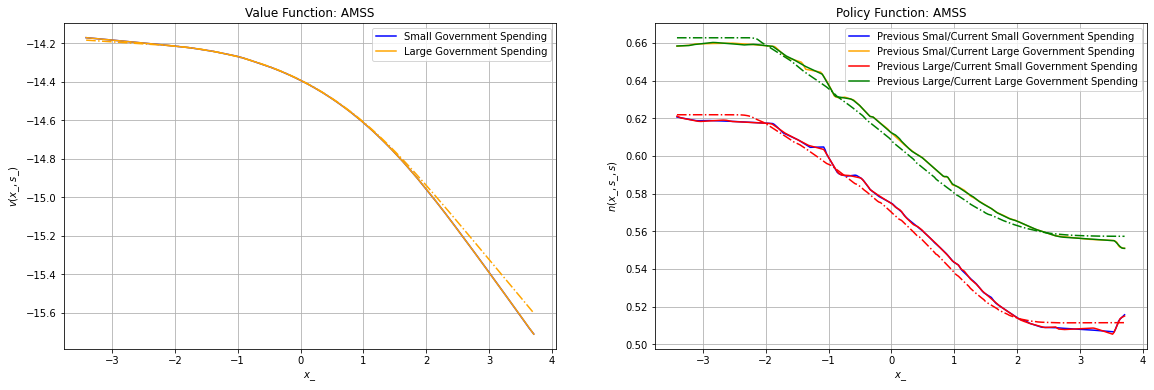

In [17]:
v_hat.eval()
state_s_0 = torch.cat((x_grid,torch.zeros(x_num,1)),1)
state_s_1 = torch.cat((x_grid,torch.ones(x_num,1)),1)
v_0 =  -softplus(v_hat(state_s_0))-14.0
v_1 =  -softplus(v_hat(state_s_1))-14.0

n_hat.eval()
state_s_00 = torch.cat((state_s_0,torch.zeros(x_num,1)),1)
state_s_01 = torch.cat((state_s_0,torch.ones(x_num,1)),1)
state_s_10 = torch.cat((state_s_1,torch.zeros(x_num,1)),1)
state_s_11 = torch.cat((state_s_1,torch.ones(x_num,1)),1)
n_s_00 = g[0]+(1-g[0])*n_hat(state_s_00)
n_s_01 = g[1]+(1-g[1])*n_hat(state_s_01)
n_s_10 = g[0]+(1-g[0])*n_hat(state_s_10)
n_s_11 = g[1]+(1-g[1])*n_hat(state_s_11)
T_s_00 = Bound_T*T_hat(state_s_00)
T_s_01 = Bound_T*T_hat(state_s_01)
T_s_10 = Bound_T*T_hat(state_s_10)
T_s_11 = Bound_T*T_hat(state_s_11)


plt.figure().set_size_inches(30,6)
plt.subplot(1,3,1)
plt.plot(x_grid,v_0.detach(),label= r"Small Government Spending",color='blue')
plt.plot(x_grid,v_1.detach(),label= r"Large Government Spending",color='orange')
plt.plot(x_grid,v_amss,color='orange',linestyle='-.')
plt.xlabel("$x\_$")
plt.ylabel("$v(x\_,s\_)$")
plt.title("Value Function: AMSS")
plt.legend(loc='best')
plt.grid()
plt.subplot(1,3,2)
plt.plot(x_grid,n_s_00.detach(),label= r"Previous Smal/Current Small Government Spending",color='blue')
plt.plot(x_grid,n_s_01.detach(),label= r"Previous Smal/Current Large Government Spending",color='orange')
plt.plot(x_grid,n_s_10.detach(),label= r"Previous Large/Current Small Government Spending",color='red')
plt.plot(x_grid,n_s_11.detach(),label= r"Previous Large/Current Large Government Spending",color='green')
plt.plot(x_grid,σ_v_star_1,color='red',linestyle='-.')
plt.plot(x_grid,σ_v_star_2,color='green',linestyle='-.')
plt.xlabel("$x\_$")
plt.ylabel("$n(x\_,s\_,s)$")
plt.title("Policy Function: AMSS")
plt.legend(loc='best')
plt.grid()